##  1 赛题介绍：

本赛题由 2020 CCF BDCI 遥感影像地块分割 初赛赛题改编而来。遥感影像地块分割, 旨在对遥感影像进行像素级内容解析，对遥感影像中感兴趣的类别进行提取和分类，在城乡规划、防汛救灾等领域具有很高的实用价值，在工业界也受到了广泛关注。现有的遥感影像地块分割数据处理方法局限于特定的场景和特定的数据来源，且精度无法满足需求。因此在实际应用中，仍然大量依赖于人工处理，需要消耗大量的人力、物力、财力。本赛题旨在衡量遥感影像地块分割模型在多个类别（如建筑、耕地、林地等）上的效果，利用人工智能技术，对多来源、多场景的异构遥感影像数据进行充分挖掘，打造高效、实用的算法，提高遥感影像的分析提取能力。 赛题任务 本赛题旨在对遥感影像进行像素级内容解析，并对遥感影像中感兴趣的类别进行提取和分类，以衡量遥感影像地块分割模型在多个类别（如建筑、耕地、林地等）上的效果。

##  2 数据集的准备
训练数据集

    训练数据集文件名称：train_and_label.zip，包含2个子文件，分别为：训练数据集（原始图片）文件、训练数据集（标注图片）文件，详细介绍如下：

    训练数据集（原始图片）文件名称：img_train

    包含66,653张分辨率为2m/pixel，尺寸为256 * 256的JPG图片，每张图片的名称形如T000123.jpg。

    训练数据集（标注图片）文件名称：lab_train

    包含66,653张分辨率为2m/pixel，尺寸为256 * 256的PNG图片，每张图片的名称形如T000123.png。

    备注： 全部PNG图片共包括4种分类，像素值分别为0、1、2、3。此外，像素值255为未标注区域，表示对应区域的所属类别并不确定，在评测中也不会考虑这部分区域。

测试数据集

    测试数据集文件名称：img_test.zip，详细介绍如下：

    包含4,609张分辨率为2m/pixel，尺寸为256 * 256的JPG图片，文件名称形如123.jpg。

In [1]:
##解压数据集到work目录
!unzip -oq -d /home/aistudio/work/data /home/aistudio/data/data77571/train_and_label.zip
!unzip -oq -d /home/aistudio/work/data /home/aistudio/data/data77571/img_test.zip

In [2]:
##生成训练标签
!python /home/aistudio/work/prepare_data.py

##  3 实验平台搭建
本项目完全采用paddleseg套件实现遥感影像地块的分割，paddleseg版本号为v2.1版本

In [ ]:
##下载安装paddlesegv2.1版本
!git clone -b release/2.1 https://gitee.com/paddlepaddle/PaddleSeg.git

In [ ]:
## 在PaddleSeg/paddleseg/datasets中添加python文件remote_sensing.py
## 在PaddleSeg/paddleseg/datasets中的__init__.py文件，添加如下代码：
    from .remote_sensing import RemoteSensing


##  4 模型训练与验证，预测
本项目完全采用2020年由微软研究院提出的OCR+HRNet方案，batchsize设置为24，迭代次数设置为150K。

In [ ]:
## 模型训练
!python /home/aistudio/PaddleSeg/train.py --config /home/aistudio/PaddleSeg/configs/ocrnet/ocrnet_hrnetw48_remotesensing_256x256.yml --do_eval --use_vdl --save_interval 5000 --resume_model work/ocrnet_check/iter_80000 --save_dir work/ocrnet_check/

2021-11-04 10:23:46 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddlePaddle: 2.1.2
OpenCV: 4.1.1
------------------------------------------------
mode train /home/aistudio/work/data/train_list.txt /home/aistudio/work/data
Total data for train : 63319
mode val /home/aistudio/work/data/val_list.txt /home/aistudio/work/data
Total data for val : 3333
mode train /home/aistudio/work/data/train_list.txt /home/aistudio/work/data
Total data for train : 63319
mode train /home/aistudio/work/data/train_list.txt /home/aistudio/work/data
Total data for train : 63319
mode train /home/aistudio/work/data/train_list.txt /home/aistudio/work/data
Total da

In [ ]:
##模型的预测，遥感图像的预测结果存放在work/result/文件中
!python /home/aistudio/PaddleSeg/predict.py --config /home/aistudio/PaddleSeg/configs/ocrnet/ocrnet_hrnetw48_remotesensing_256x256.yml --model_path /home/aistudio/work/ocrnet_check/iter_80000/model.pdparams --image_path /home/aistudio/work/data/img_testA --save_dir /home/aistudio/work/result

##  5 有关实验网络的详细介绍
微软亚洲研究院提出的 OCR 方法的主要思想是显式地把像素分类问题转化成物体区域分类问题，这与语义分割问题的原始定义是一致的，即每一个像素的类别就是该像素属于的物体的类别，换言之，与 PSPNet 和 DeepLabv3+ 的上下文信息最主要的不同就在于 OCR 方法显式地增强了物体信息。

OCR 方法的实现主要包括3个阶段，并给出每个阶段的矩阵表示(具体的计算过程可参考其开源的代码)：

（1）从骨干网络得到特征表示，并估测一个简单粗略的语义分割结果作为 OCR 方法的一个输入 ，即软物体区域（Soft Object Regions），矩阵表示为b*c*h*w；

（2）根据软物体区域（b*c*h*w）和网络最深层输入的特征表示(b*k*h*w)表示计算出 K 组向量，即物体区域表示（Object Region Representations），其中每一个向量对应一个语义类别的特征表示，矩阵表示为b*c*k*1;

（3）计算网络最深层输出的像素特征表示（Pixel Representations）与计算得到的物体区域特征表示（Object Region Representation）之间的关系矩阵(b*(h*w)*k)，然后根据每个像素和物体区域特征表示在关系矩阵中的数值把物体区域特征加权求和，得到最后的物体上下文特征表示 OCR (Object Contextual Representation)，矩阵表示为b*k*h*w 。

当把物体上下文特征表示 OCR (b*k*h*w)与网络最深层输入的特征表示(b*k*h*w)拼接之后作为上下文信息增强的特征表示（Augmented Representation）(b*2k*h*w)，可以基于增强后的特征表示预测每个像素的语义类别，也可拼接上ASPP特征,即OCR+Features+ASPP，具体算法框架可以参考图5。

综上，OCR 可计算一组物体区域的特征表达，然后根据物体区域特征表示与像素特征表示之间的相似度将这些物体区域特征表示传播给每一个像素。
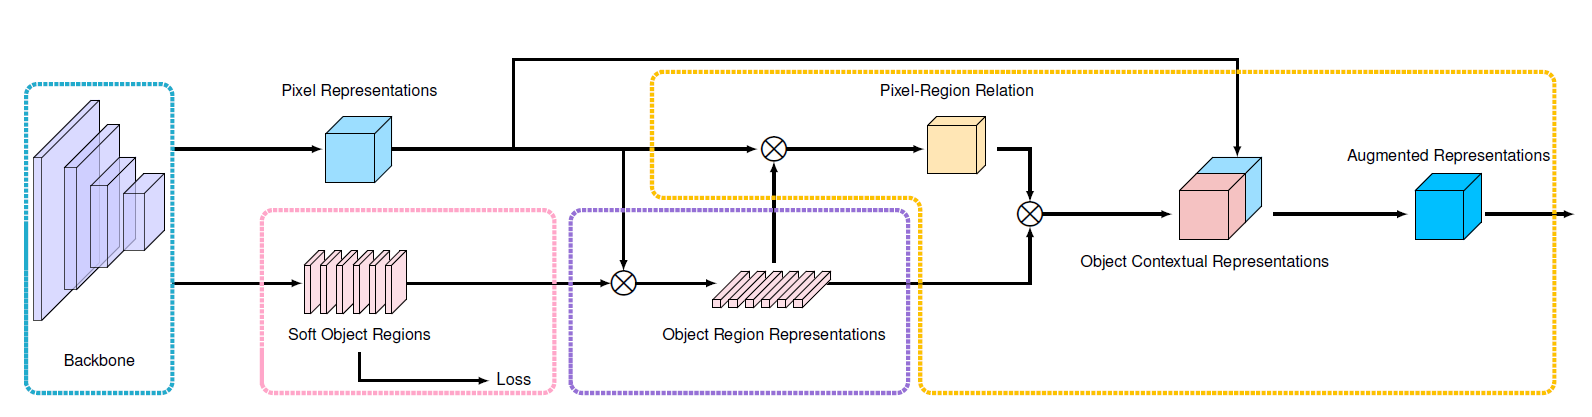

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 